In [301]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread
from skimage.transform import ProjectiveTransform

from image import get_patch
from vis import plot_images, plot_with_keypoints
from tools import invert_coords
from tools import trim_coords_to_shape, get_keypoints, get_keypoints_random
from sklearn.metrics import roc_auc_score

from HuMomentsDescriptor import HuMomentsDescriptor

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
H1to2 = np.loadtxt('images/blur-1/H1to2p')
H1to3 = np.loadtxt('images/blur-1/H1to3p')
H1to4 = np.loadtxt('images/blur-1/H1to4p')
H1to5 = np.loadtxt('images/blur-1/H1to5p')
H1to6 = np.loadtxt('images/blur-1/H1to6p')

img1 = imread('images/blur-1/img1.ppm', as_grey=True)
img2 = imread('images/blur-1/img2.ppm', as_grey=True)
img3 = imread('images/blur-1/img3.ppm', as_grey=True)
img4 = imread('images/blur-1/img4.ppm', as_grey=True)
img5 = imread('images/blur-1/img5.ppm', as_grey=True)
img6 = imread('images/blur-1/img6.ppm', as_grey=True)


coords1 = get_keypoints(img1)

plot_images([img1, img2, img3, img4, img5, img6])
plot_with_keypoints(img1, coords1)

transs = ProjectiveTransform(H1to5)
coords5 = trim_coords_to_shape(img5.shape, transs(coords1))
plot_with_keypoints(img5, coords5[31:])

transs = ProjectiveTransform(H1to3)
coords3 = trim_coords_to_shape(img3.shape, transs(coords1))
plot_with_keypoints(img3, coords3[0:2])

# plot_with_keypoints(img3, coords3)

In [ ]:
mom_desc = HuMomentsDescriptor()
desc = mom_desc.extract(img1, coords1)

transs = ProjectiveTransform(H1to3)
coords3 = trim_coords_to_shape(img3.shape, transs(coords1))

desc3 = mom_desc.extract(img3, coords3)

transs = ProjectiveTransform(H1to5)
coords5 = trim_coords_to_shape(img5.shape, transs(coords1))

desc5 = mom_desc.extract(img5, coords5)

for i in range(80):
    print("{:<10.5f}".format(mom_desc.distance(desc3[0], desc5[i-1])), "{:<10.5f}".format(mom_desc.distance_correlation(desc3[0], desc5[i-1])), "{:<10.5f}".format(mom_desc.distance_canberra(desc3[0], desc5[i-1])), "{:<10.5f}".format(mom_desc.distance_braycurtis(desc3[0], desc5[i-1])))


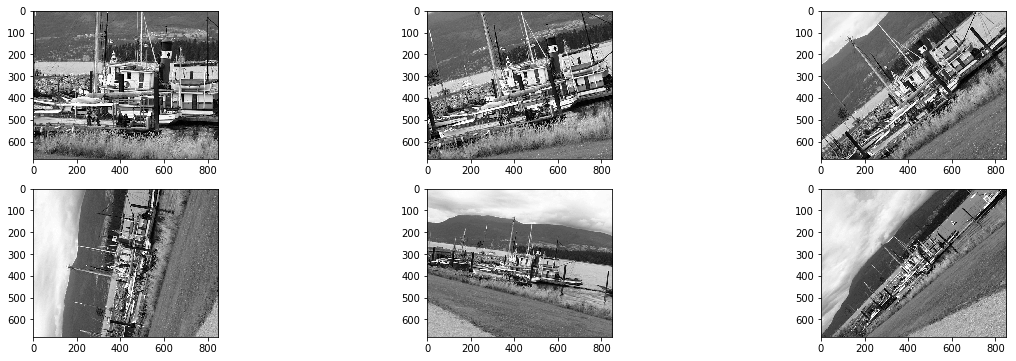

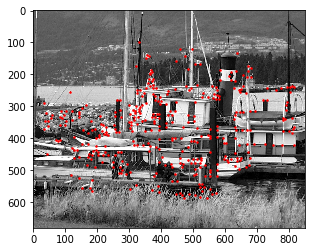

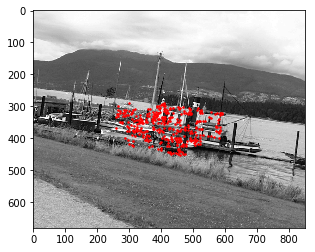

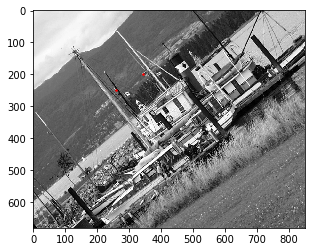

In [137]:
H1to2 = np.loadtxt('images/zoom-rotation-2/H1to2p')
H1to3 = np.loadtxt('images/zoom-rotation-2/H1to3p')
H1to4 = np.loadtxt('images/zoom-rotation-2/H1to4p')
H1to5 = np.loadtxt('images/zoom-rotation-2/H1to5p')
H1to6 = np.loadtxt('images/zoom-rotation-2/H1to6p')

img1 = imread('images/zoom-rotation-2/img1.pgm', as_grey=True)
img2 = imread('images/zoom-rotation-2/img2.pgm', as_grey=True)
img3 = imread('images/zoom-rotation-2/img3.pgm', as_grey=True)
img4 = imread('images/zoom-rotation-2/img4.pgm', as_grey=True)
img5 = imread('images/zoom-rotation-2/img5.pgm', as_grey=True)
img6 = imread('images/zoom-rotation-2/img6.pgm', as_grey=True)


coords1 = get_keypoints(img1)

plot_images([img1, img2, img3, img4, img5, img6])
plot_with_keypoints(img1, coords1)

transs = ProjectiveTransform(H1to5)
# coords5 = trim_coords_to_shape(img5.shape, transs(coords1))
coords5 = transs(coords1)
plot_with_keypoints(img5, coords5[31:])

transs = ProjectiveTransform(H1to3)
coords3 = transs(coords1)
# coords3 = trim_coords_to_shape(img3.shape, transs(coords1))
plot_with_keypoints(img3, coords3[0:2])

# plot_with_keypoints(img3, coords3)

In [335]:
from generate_patches import read_image_set
from os import path

names = [('blur-1', 'ppm'),
         ('blur-2', 'ppm'),
         ('jpeg-compression', 'ppm'),
         ('light', 'ppm'),
         ('viewpoint-1', 'ppm'),
         ('viewpoint-2', 'ppm'),
         ('zoom-rotation-1', 'ppm'),
         ('zoom-rotation-2', 'pgm')]

image_sets = {}

for name, extension in names:
    image_sets[name] = read_image_set(path.join('./images', name), extension=extension)
    

In [366]:
# znajdujemy punkty do analizy, dla kazdego ze zdjec

keypoint_dataset = {}

for name, _ in names:
    base_keypoints = []
    for j, image in enumerate(image_sets[name]):
        if (j == 0):
            base_keypoints = get_keypoints(image[0])
            keypoint_dataset[name] = [convert_to_indexed_tuple(base_keypoints)]
            continue
            
        trans = ProjectiveTransform(image[1])
        transformed_keypoints = convert_to_indexed_tuple(trans(base_keypoints))
        
        for k, point in enumerate(transformed_keypoints):
            if not fits_in_image(image[0], point[1]):
                transformed_keypoints[k] = (k, None)
        
        keypoint_dataset[name].append(transformed_keypoints)


In [382]:
# ostateczna lista punktow dla kazdego ze zbiorow, gdzie kazdy punkt znajduje sie we wszystkich 6 obrazkach - czasami brakuje odpowiadajacego punktu w innych, bo znajduje sie za blisko krawedzi (< 32 px) - funkcja trim_to_shape

keypoint_dataset_valid_indexes = {}

for name, _ in names:
    all_indexes = []
    for i, image_keypoints in enumerate(keypoint_dataset[name]):
        all_indexes.append([k_point[0] for k_point in image_keypoints if k_point[1] is not None])
    
    flat = np.concatenate(all_indexes).tolist()
    valid = [x for x in flat if flat.count(x) == 6]
    keypoint_dataset_valid_indexes[name] = np.unique(valid).tolist()
    

In [389]:
# konstrukcja listy deskryptorow, gdzie [0] to index, [1] wartosc deskryptora, a [2] to wektor mowiacy, do ktorych punktow tak na prawde jest podobny - wartosci 0 lub 1

mom_desc = HuMomentsDescriptor()

image_descriptors = {}

for name, _ in names:
    descriptors = []
    for i, image in enumerate(keypoint_dataset[name]):
        for point in image:
            if (point[0] in keypoint_dataset_valid_indexes[name]):
                desc = mom_desc.extract(image_sets[name][i][0], [point[1]])
                descriptors.append((point[0], desc))
    image_descriptors[name] = descriptors

for name, _ in names:
    for i, desc in enumerate(image_descriptors[name]):
        labels = generate_labels(desc[0], image_descriptors[name])
        image_descriptors[name][i] = desc + (labels, )


In [388]:
def generate_labels(index, collection):
    return list(map(lambda x: 0 if x[0] == index else 1, collection))

def convert_to_indexed_tuple(collection):
    return [(i, x) for i, x in enumerate(collection)]

In [396]:
# obliczanie ROC, dla kazdego zbioru, kazdy znaleziony deskryptor jest testowany z pozostalymi deskryptorami
for name, _ in names:
    scores = []
    for desc1 in image_descriptors[name]:
        y_pred = [mom_desc.distance_braycurtis(desc1[1], desc2[1]) for desc2 in image_descriptors[name]]
        y_true = desc1[2]
        scores.append(roc_auc_score(y_true, y_pred))
        
    print("Score for ", name, ": ", sum(scores) / len(scores))


Score for  blur-1 :  0.9086161514336921
Score for  blur-2 :  0.801067608556834
Score for  jpeg-compression :  0.9378044232226436
Score for  light :  0.7788790684624015
Score for  viewpoint-1 :  0.7011605260192831
Score for  viewpoint-2 :  0.7133390110631371
Score for  zoom-rotation-1 :  0.6135311447811449
Score for  zoom-rotation-2 :  0.6720196759259257
